In [2]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 18.3 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install --upgrade tensorflow tensorflow_io


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [4]:
import tensorflow_io as tfio

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [ ]:
# !pip install --upgrade tensorflow-io

In [37]:
CAPUCHIN_FILE = os.path.join('/content/drive/MyDrive/data','Parsed_Capuchinbird_Clips','XC3776-3.wav')
NOT_CAPUCHINBIRD = os.path.join('/content/drive/MyDrive/data','Parsed_Not_Capuchinbird_Clips','afternoon-birds-song-in-forest-0.wav')

In [38]:
CAPUCHIN_FILE

'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC3776-3.wav'

### Build Dataloading Function

In [39]:
def load_wav_mono(filename):
  #load the encoded wav file
  file_contents = tf.io.read_file(filename)
  #decoded wav (tensors by channels)
  wav,sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
  #removes trailing axis
  wav = tf.squeeze(wav,axis=-1)
  sample_rate = tf.cast(sample_rate,dtype=tf.int64)
  #goes from 44100HZ to 16000hz - amplitute of the audio signal
  wav = tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
  return wav

Plot Wave

In [40]:
wave = load_wav_mono(CAPUCHIN_FILE)
nwave = load_wav_mono(NOT_CAPUCHINBIRD)

In [48]:
wave

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 8.9910554e-07, -2.7947258e-06,  7.0741157e-06, ...,
       -1.0823049e-02, -3.5766482e-03,  1.5143131e-02], dtype=float32)>

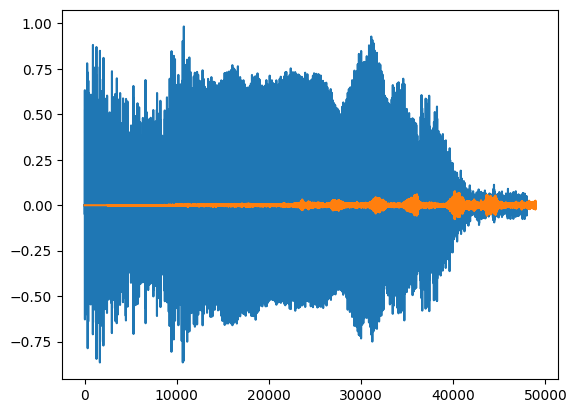

In [41]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

### Create Tensorflow Dataset

In [ ]:
#define paths to positive and negative data

POS = os.path.join("/content/drive/MyDrive/data",'Parsed_Capuchinbird_Clips')

NEG = os.path.join("/content/drive/MyDrive/data",'Parsed_Not_Capuchinbird_Clips')

In [ ]:
POS

'/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips'

Create Tensorflow Datasets

In [ ]:
pos = tf.data.Dataset.list_files("/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips"+'/*.wav')

neg = tf.data.Dataset.list_files("/content/drive/MyDrive/data/Parsed_Not_Capuchinbird_Clips"+'/*.wav')

In [ ]:
positives = tf.data.Dataset.zip(pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos))))
# positives = positives.take(150)
negatives = tf.data.Dataset.zip(neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg))))
negatives = negatives.take(200)
data = positives.concatenate(negatives)

In [ ]:
len(data)

417

In [ ]:
data.shuffle(10000).as_numpy_iterator().next()

(b'/content/drive/MyDrive/data/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-31.wav',
 0.0)

### Determine The Average Length of Capuchin Call

In [ ]:
lengths = []

for file in os.listdir(os.path.join('/content/drive/MyDrive/data','Parsed_Capuchinbird_Clips')):
  tensor_wave = load_wav_mono(os.path.join('/content/drive/MyDrive/data','Parsed_Capuchinbird_Clips',file))
  lengths.append(len(tensor_wave))

In [ ]:
lengths[:4]

[56000, 56000, 64000, 56000]

### Lets Calculate Mean,Min,Max

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

### Build Preprocessing Function to Convert to Spectrogram

In [7]:
def preprocess(file_path,label):
  wav = load_wav_mono(file_path)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
  wav = tf.concat([zero_padding,wav],0)
  spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram,axis=2)
  return spectrogram, label

In [ ]:
wav = load_wav_mono('/content/drive/MyDrive/data/Parsed_Capuchinbird_Clips/XC16803-2.wav')
wav = wav[:48000]
zero_padding = tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
wav = tf.concat([zero_padding,wav],0)

In [ ]:
spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram,axis=2)

In [ ]:
spectrogram

<tf.Tensor: shape=(1491, 257, 1), dtype=float32, numpy=
array([[[8.27122974e+00],
        [1.17637186e+01],
        [1.15549593e+01],
        ...,
        [1.48529225e-05],
        [3.42734493e-05],
        [5.05447388e-05]],

       [[1.54808540e+01],
        [1.52953787e+01],
        [1.18630733e+01],
        ...,
        [9.79154793e-05],
        [5.19949317e-05],
        [2.38418579e-06]],

       [[1.98955727e+01],
        [1.78140717e+01],
        [1.21536951e+01],
        ...,
        [2.00285795e-05],
        [5.81448112e-05],
        [2.00271606e-05]],

       ...,

       [[1.37326927e+01],
        [1.21594782e+01],
        [7.60072422e+00],
        ...,
        [7.54534540e-06],
        [6.08789596e-05],
        [2.05039978e-05]],

       [[9.20616436e+00],
        [9.70711517e+00],
        [7.79897976e+00],
        ...,
        [1.53867750e-05],
        [5.33120146e-05],
        [1.43051147e-05]],

       [[3.61834979e+00],
        [7.39751863e+00],
        [7.86673403e+00]

### Test Out The Function And Viz The Spectrogram

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

spectrogram, label = preprocess(filepath, label)

In [ ]:
len(spectrogram)

1491

In [ ]:
# tf.transpose(spectrogram)[0]

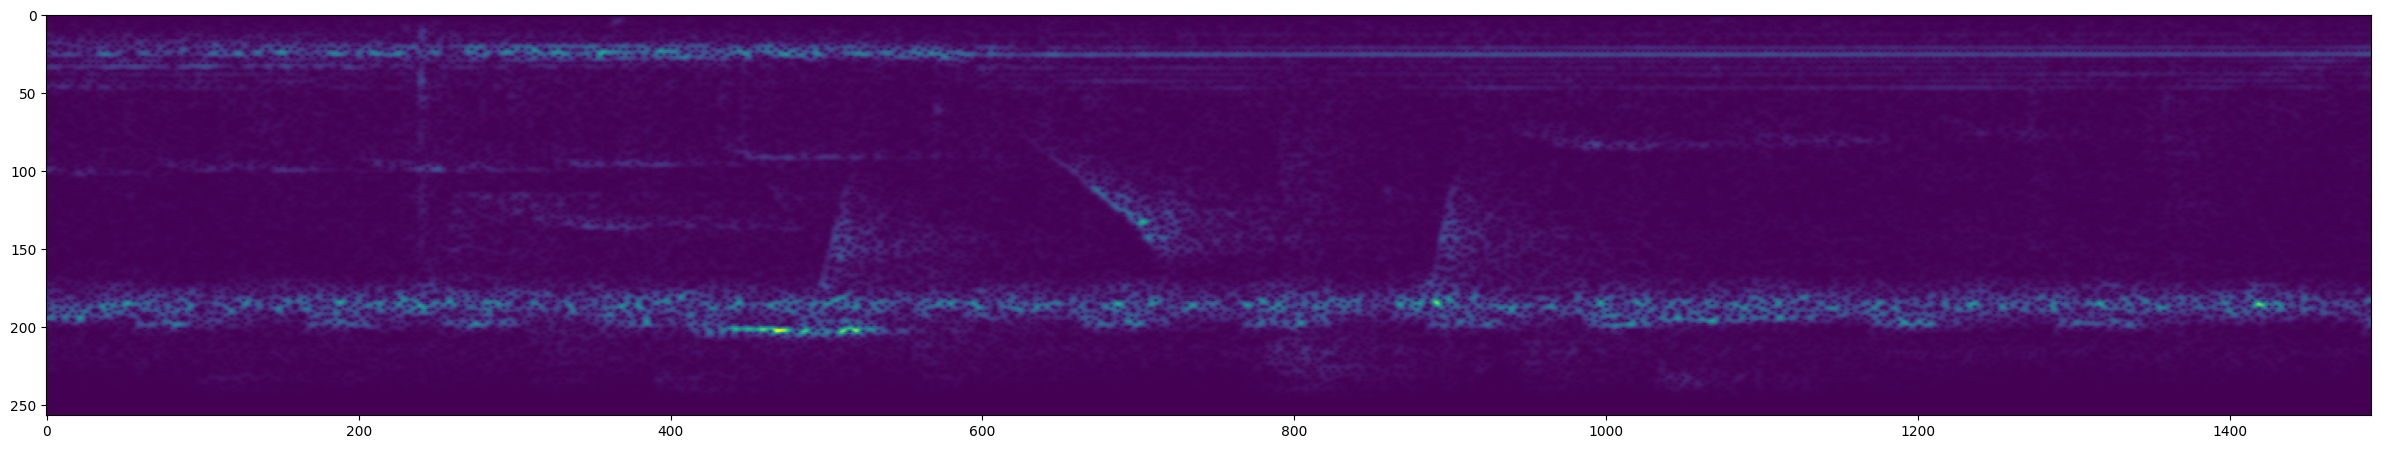

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### Create Training and Testing Partitions


Create a Tensorflow Data Pipeline

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

### Split into Training and Testing Partions

In [ ]:
len(data)

27

In [ ]:
len(data)*.7

18.9

In [ ]:
train = data.take(19)
test = data.skip(19)

In [ ]:
len(train),len(test)

(19, 8)

### Test One Batch

In [ ]:
# sample,label = train.as_numpy_iterator().next()

In [ ]:
# sample[0][0].shape

### Build Deep Learning Model

Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten

### Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential([
    Conv2D(10,(3,3),activation='relu',input_shape=(1491,257,1)),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1,activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 10)     100       
                                                                 
 flatten (Flatten)           (None, 3796950)           0         
                                                                 
 dense (Dense)               (None, 50)                189847550 
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 189847701 (724.21 MB)
Trainable params: 189847701 (724.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

In [ ]:
history = model.fit(train,epochs=10,validation_data=test)

Epoch 1/10
19/19 [==============================] - 65s 133ms/step - loss: 7.8877 - acc: 0.8947 - val_loss: 2.8916 - val_acc: 0.9558
Epoch 2/10
19/19 [==============================] - 3s 135ms/step - loss: 1.8107 - acc: 0.9605 - val_loss: 0.5053 - val_acc: 0.9823
Epoch 3/10
19/19 [==============================] - 2s 120ms/step - loss: 1.8562 - acc: 0.9934 - val_loss: 0.0306 - val_acc: 0.9912
Epoch 4/10
19/19 [==============================] - 2s 114ms/step - loss: 0.5730 - acc: 0.9934 - val_loss: 0.6170 - val_acc: 0.9735
Epoch 5/10
19/19 [==============================] - 2s 115ms/step - loss: 0.6103 - acc: 0.9803 - val_loss: 0.1598 - val_acc: 0.9912
Epoch 6/10
19/19 [==============================] - 2s 123ms/step - loss: 0.0807 - acc: 0.9934 - val_loss: 6.2321e-04 - val_acc: 1.0000
Epoch 7/10
19/19 [==============================] - 3s 137ms/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0198 - val_acc: 1.0000
Epoch 8/10
15/19 [======================>.......] - ETA: 0s - loss: 0.0

KeyboardInterrupt: 

In [ ]:
model.save(r'/content/drive/MyDrive/data/capuchin_bird_audio.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
bird_model = tf.keras.models.load_model(r'/content/drive/MyDrive/data/capuchin_bird_audio.h5')

In [76]:
def test_preprocess_1(file_path):
  wav = load_wav_mono(file_path)
  wav = wav[:48000]
  zero_padding = tf.zeros([48000]-tf.shape(wav),dtype=tf.float32)
  wav = tf.concat([zero_padding,wav],0)
  spectrogram = tf.signal.stft(wav,frame_length=320,frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram,axis=2)
  spectrogram = tf.expand_dims(spectrogram,axis=0)
  return spectrogram

In [22]:
!pip install pydub

#### Convert m4a file to wav

In [108]:
from pydub import AudioSegment

def convert_mp3_to_wav(mp3_path, wav_path):
    # Read MP3 file
    audio = AudioSegment.from_file(mp3_path, format="m4a")

    # Export as WAV file
    audio.export(wav_path, format="wav")

# Example usage
mp3_file = '/content/drive/MyDrive/data/capuchin_audio.m4a'
wav_file = '/content/drive/MyDrive/data/capuchin_audio.wav'

convert_mp3_to_wav(mp3_file, wav_file)

#### Convert mp3 file to wav

In [114]:
from pydub import AudioSegment

def convert_mp3_to_wav(mp3_path, wav_path):
    # Read MP3 file
    audio = AudioSegment.from_mp3(mp3_path)

    # Export as WAV file
    audio.export(wav_path, format="wav")

# Example usage
mp3_file = ''
wav_file = ''

convert_mp3_to_wav(mp3_file, wav_file)

In [116]:
test_sample_1= test_preprocess_1('/content/drive/MyDrive/data/capuchin_audio.wav')

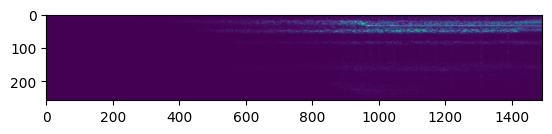

In [117]:
plt.imshow(tf.transpose(test_sample_1)[0])

In [118]:
predicted = bird_model.predict(test_sample_1)

1/1 [==============================] - 0s 57ms/step


In [119]:
print('capuchin bird') if predicted[0][0] >0.5 else 'not a capuchin bird'

capuchin bird
